In [1]:
import os
import sys
sys.path.append(os.path.join(os.path.expanduser("~"), "datacube_jupyter_notebooks/"))
import helpers.helpers as helpers

from DQTools.dataset import Dataset

import xarray as xr

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt

import pandas as pd

from scipy.stats import spearmanr
from scipy import stats
import numpy as np

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
def read_station_data(fname):
    station = pd.read_csv(fname)

    # Convert date to datetime
    station.date = pd.to_datetime(station.date, format='%d-%m-%Y').astype(np.datetime64)
    station = station.set_index('date')
    
    return station

def get_adjusted_data_from_geopot_height(data, elevation, elev_geopotential, subproduct):
    
    # Temperature rate of change when elevation increases (°C/m)
    temp_rate = -0.0065

    getattr(data, subproduct).data -= ((elev_geopotential-elevation) * temp_rate)
    
    return data

def get_data_from_datacube(product, subproduct, start, end,
                           latitude, longitude):

    keyfile = os.path.join(os.path.expanduser("~"), 'assimila_dq.txt')
    
    ds = Dataset(product=product, subproduct=subproduct,
                 key_file=keyfile)

    ds.get_data(start=start, stop=end,
                latlon=[latitude, longitude])
    
    # Transform to local time
    getattr(ds.data, subproduct).time.data -= np.timedelta64(5,'h')
    
    ds.data = ds.data.sel(time=slice('2018-01-01', '2018-12-31'))
    
    return ds.data

def get_data_for_station(product, subproduct, lat, lon, elevation, elev_geopotential, start, end):
    era5_t2m = get_data_from_datacube(product, subproduct,
                                  start, end,
                                  lat, lon)

    # Get adjusted by geopotential height       
    era5_t2m_adjusted = get_adjusted_data_from_geopot_height(
                era5_t2m.copy(deep=True), elevation, elev_geopotential, subproduct)

    # Kelvin to Celcius
    getattr(era5_t2m, subproduct).data = getattr(era5_t2m, subproduct).data - 273.15
    getattr(era5_t2m_adjusted, subproduct).data = getattr(era5_t2m_adjusted, subproduct).data -273.15

    return era5_t2m, era5_t2m_adjusted


## ERA5 t2m assessment

The CENICAFE AgroClima portal (https://agroclima.cenicafe.org/) provides daily aggregations for different stations in Colombia. The following plots show an assessment of the Assimila adjusted air temperature using the in-situ daily aggregations from different statios in Colombia.

## Cenicafé station in Caldas, Chinchiná
 * **Latitude:** 5.0 **Longitude:** -75.6 **Elevation:** 1310m

In [3]:
# Get ERA5 data
product = 'era5'
subproduct = 't2m'

start = '2018-01-01'
end = '2019-01-01'

# (base) glopez@dragon:/media/DataShare/Taylor/COLOMBIA/era5$ gdallocationinfo -wgs84 orography.tif -75.6 5.0
# Report:
#   Location: (30P,34L)
#   Band 1:
#     Value: -27039
#      Descaled Value: 2410.87228781236

# Elevation derived from ERA5 surface geopotential (m)
# elev_geopotential = 2410.87228781236

site_name = 'Cenicafe.Caldas.Chinchina'
fname = f'../data/{site_name}.csv'
station = read_station_data(fname)

lat, lon = 5.0, -75.6
elevation, elev_geopotential = 1310.0, 2410.87228781236

era5_t2m, era5_t2m_adjusted = get_data_for_station(product, subproduct, lat, lon, elevation, elev_geopotential, start, end)

<IPython.core.display.Javascript object>


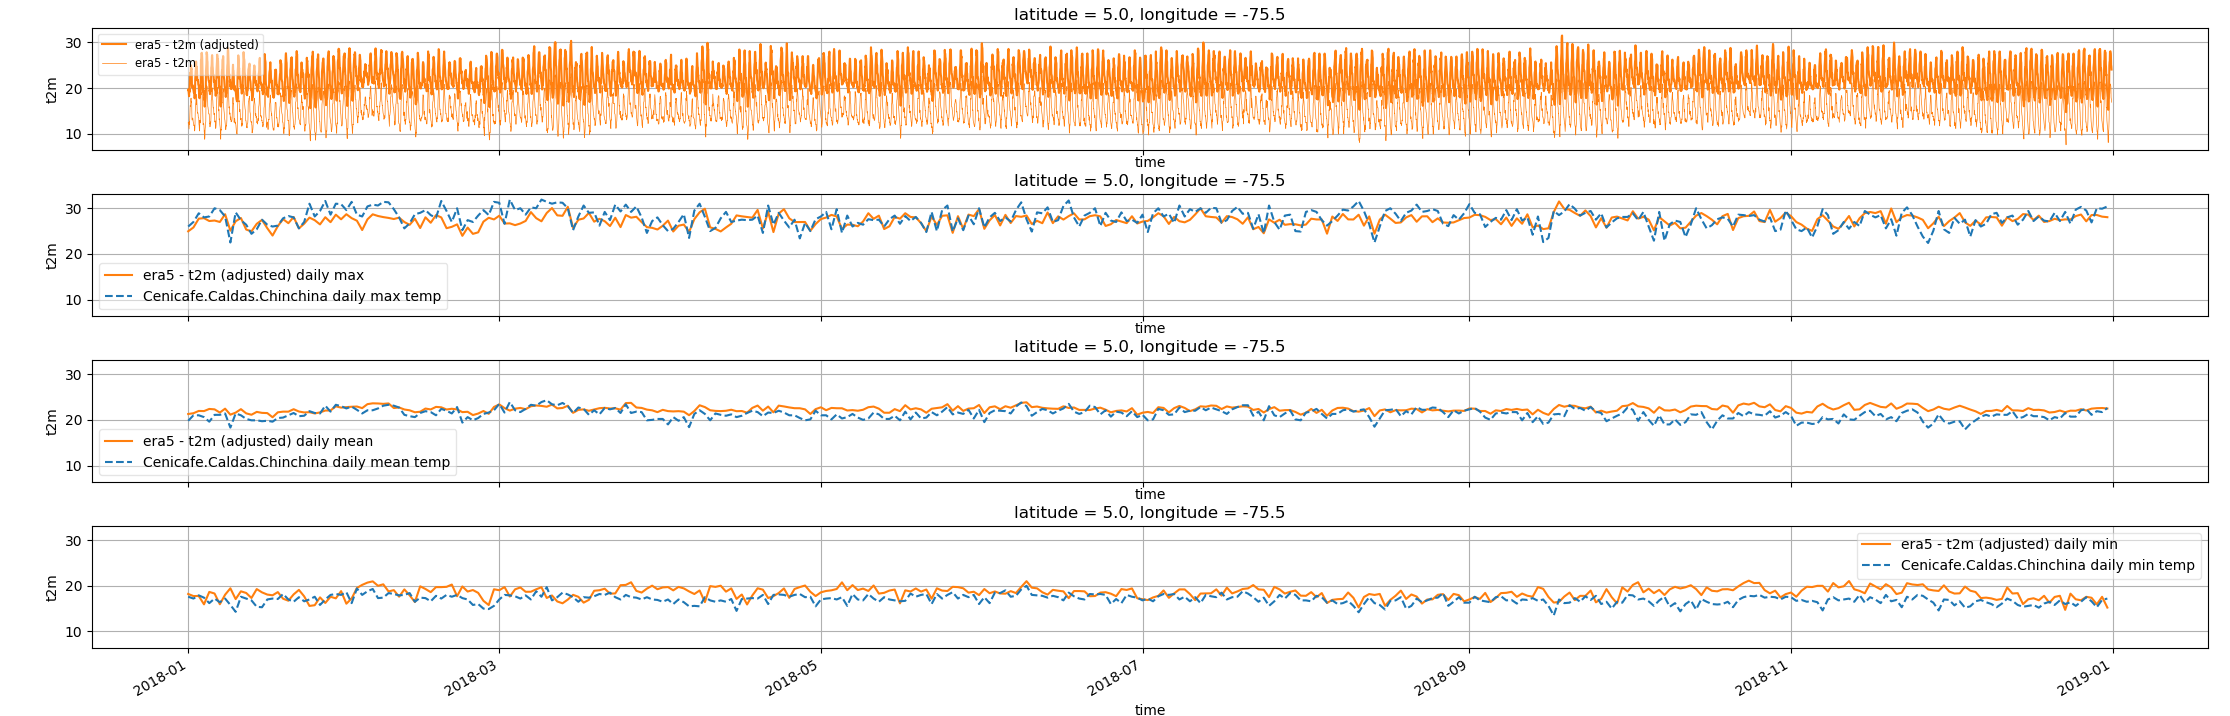

In [4]:
# Plot ERA5 t2m data

fig, (ax, bx, cx, dx) = plt.subplots(4, 1, sharex=True, sharey=True)
fig.set_size_inches(15.0, 9.0)
      
# Kelvin to Celcius
getattr(era5_t2m_adjusted, subproduct).plot(ax=ax,
    label=f'{product} - {subproduct} (adjusted)', color='C1')


getattr(era5_t2m, subproduct).plot(ax=ax, label=f'{product} - {subproduct}',
                                   lw=0.5, color='C1')

ax.legend(loc='best', fontsize='small',
          fancybox=True, framealpha=0.5)

    
# Plot station data

t2m_adjusted_max = era5_t2m_adjusted.t2m.resample(time='24H').reduce(np.max)
t2m_adjusted_max.plot(ax=bx, label=f'{product} - {subproduct} (adjusted) daily max', color='C1')

bx.plot(t2m_adjusted_max.time.data, station.max_temp.values,
        label=f'{site_name} daily max temp', color='C0', ls='--')


t2m_adjusted_mean = era5_t2m_adjusted.t2m.resample(time='24H').reduce(np.mean)
t2m_adjusted_mean.plot(ax=cx, label=f'{product} - {subproduct} (adjusted) daily mean', color='C1')

cx.plot(t2m_adjusted_mean.time.data, station.mean_temp.values,
        label=f'{site_name} daily mean temp', color='C0', ls='--')


t2m_adjusted_min = era5_t2m_adjusted.t2m.resample(time='24H').reduce(np.min)
t2m_adjusted_min.plot(ax=dx, label=f'{product} - {subproduct} (adjusted) daily min', color='C1')

dx.plot(t2m_adjusted_min.time.data, station.min_temp.values,
        label=f'{site_name} daily min temp', color='C0', ls='--')

bx.legend(loc='best', fontsize='medium',
          fancybox=True, framealpha=0.5)
cx.legend(loc='best', fontsize='medium',
          fancybox=True, framealpha=0.5)
dx.legend(loc='best', fontsize='medium',
          fancybox=True, framealpha=0.5)

#station.min_temp.plot(ax=bx)
#station.max_temp.plot(ax=bx)

ax.grid() ; bx.grid() ; cx.grid() ; dx.grid()

plt.tight_layout()
plt.show()


<IPython.core.display.Javascript object>


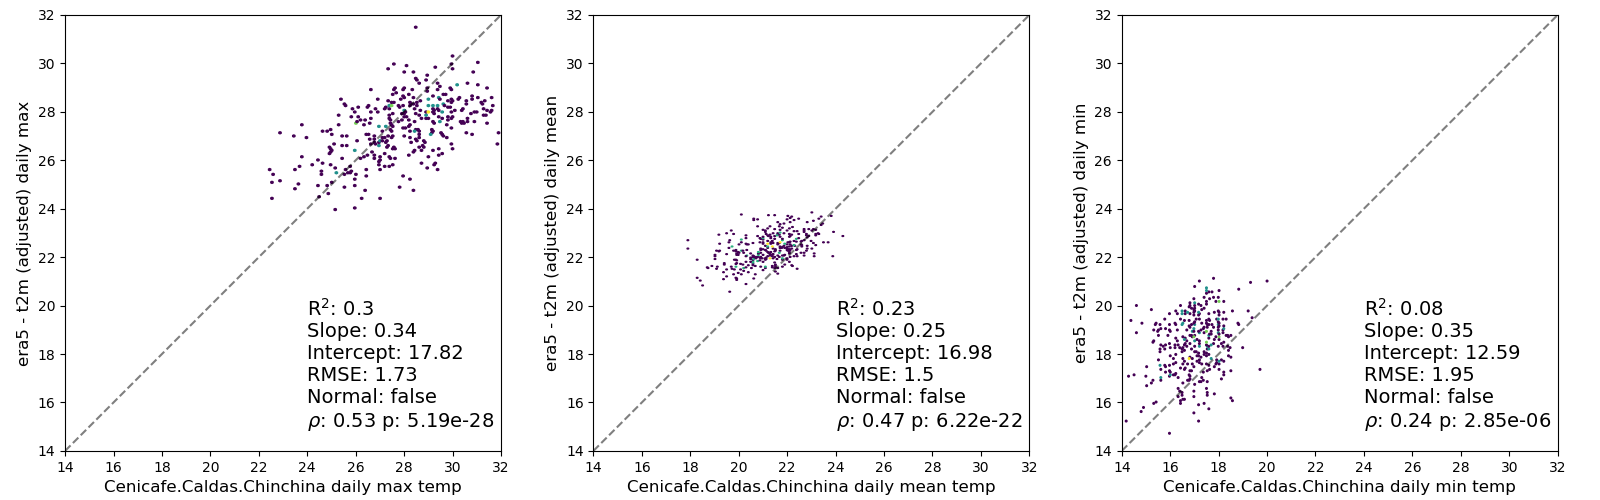

In [5]:
_fig, (_ax, _bx, _cx) = plt.subplots(1, 3)
_fig.set_size_inches(16.0, 5.0)

_ax.hexbin(station.max_temp.values, t2m_adjusted_max.values, bins='log', gridsize=100, mincnt=1)
_bx.hexbin(station.mean_temp.values, t2m_adjusted_mean.values, bins='log', gridsize=100, mincnt=1)
_cx.hexbin(station.min_temp.values, t2m_adjusted_min.values, bins='log', gridsize=100, mincnt=1)

# Linear regression and normality test
slope, intercept, r_value, p_value, std_err = stats.linregress(station.max_temp.values, t2m_adjusted_max.values)
max_r_squared = round(r_value ** 2, 2)
max_slope = round(slope, 2)
max_intercept = round(intercept, 2)
max_rmse = round(np.sqrt(np.mean((t2m_adjusted_max.values - station.max_temp.values)**2)), 2)
max_rho, max_pval = spearmanr(station.max_temp.values, t2m_adjusted_max.values)
max_rho, max_pval = round(max_rho, 2), "{:.2e}".format(max_pval)

k2, p = stats.normaltest(t2m_adjusted_max.values)
alpha = 1e-3
if p < alpha:
    max_p_text = "true"
else:
    max_p_text = "false"

slope, intercept, r_value, p_value, std_err = stats.linregress(station.mean_temp.values, t2m_adjusted_mean.values)
mean_r_squared = round(r_value ** 2, 2)
mean_slope = round(slope, 2)
mean_intercept = round(intercept, 2)
mean_rmse = round(np.sqrt(np.mean((t2m_adjusted_mean.values - station.mean_temp.values)**2)), 2)
mean_rho, mean_pval = spearmanr(station.mean_temp.values, t2m_adjusted_mean.values)
mean_rho, mean_pval = round(mean_rho, 2), "{:.2e}".format(mean_pval)

k2, p = stats.normaltest(t2m_adjusted_mean.values)
alpha = 1e-3
if p < alpha:
    mean_p_text = "true"
else:
    mean_p_text = "false"

slope, intercept, r_value, p_value, std_err = stats.linregress(station.min_temp.values, t2m_adjusted_min.values)
min_r_squared = round(r_value ** 2, 2)
min_slope = round(slope, 2)
min_intercept = round(intercept, 2)
min_rmse = round(np.sqrt(np.mean((t2m_adjusted_min.values - station.min_temp.values)**2)), 2)
min_rho, min_pval = spearmanr(station.min_temp.values, t2m_adjusted_min.values)
min_rho, min_pval = round(min_rho, 2), "{:.2e}".format(min_pval)

k2, p = stats.normaltest(t2m_adjusted_min.values)
alpha = 1e-3
if p < alpha:
    min_p_text = "true"
else:
    min_p_text = "false"

# Plot regression results
_ax.text(24, 15,
         "R$^{2}$: " + str(max_r_squared) +  "\n"\
         "Slope: " + str(max_slope) +  "\n"\
         "Intercept: " + str(max_intercept) +  "\n"\
         "RMSE: " + str(max_rmse) +  "\n"\
         "Normal: " + max_p_text  +  "\n"\
         "$\\rho$: " + str(max_rho) + " p: " + str(max_pval),
          size=14)

_bx.text(24, 15,
         "R$^{2}$: " + str(mean_r_squared) +  "\n"\
         "Slope: " + str(mean_slope) +  "\n"\
         "Intercept: " + str(mean_intercept) +  "\n"\
         "RMSE: " + str(mean_rmse) +  "\n"\
         "Normal: " + mean_p_text  +  "\n"\
         "$\\rho$: " + str(mean_rho) + " p: " + str(mean_pval),
          size=14)

_cx.text(24, 15,
         "R$^{2}$: " + str(min_r_squared) +  "\n"\
         "Slope: " + str(min_slope) +  "\n"\
         "Intercept: " + str(min_intercept) +  "\n"\
         "RMSE: " + str(min_rmse) +  "\n"\
         "Normal: " + min_p_text  +  "\n"\
         "$\\rho$: " + str(min_rho) + " p: " + str(min_pval),
          size=14)

_ax.set_aspect('equal')
_bx.set_aspect('equal')
_cx.set_aspect('equal')

_ax.set(xlim=(14.0, 32.0), ylim=(14.0, 32.0))
_bx.set(xlim=(14.0, 32.0), ylim=(14.0, 32.0))
_cx.set(xlim=(14.0, 32.0), ylim=(14.0, 32.0))

_ax.plot([14,32], [14,32], '--', color='black', alpha=0.5)
_bx.plot([14,32], [14,32], '--', color='black', alpha=0.5)
_cx.plot([14,32], [14,32], '--', color='black', alpha=0.5)

_ax.set_xlabel(f'{site_name} daily max temp', fontsize=12)
_bx.set_xlabel(f'{site_name} daily mean temp', fontsize=12)
_cx.set_xlabel(f'{site_name} daily min temp', fontsize=12)

_ax.set_ylabel(f'{product} - {subproduct} (adjusted) daily max', fontsize=12)
_bx.set_ylabel(f'{product} - {subproduct} (adjusted) daily mean', fontsize=12)
_cx.set_ylabel(f'{product} - {subproduct} (adjusted) daily min', fontsize=12)


_fig.tight_layout()

plt.show()

## Granja Luker station in Caldas, Palestina
 * **Latitude:** 5.067 **Longitude:** -75.683 **Elevation:** 1031m

In [6]:
# Get ERA5 data
product = 'era5'
subproduct = 't2m'

start = '2018-01-01'
end = '2019-01-01'

# (base) glopez@dragon:/media/DataShare/Taylor/COLOMBIA/era5$ gdallocationinfo -wgs84 orography.tif -75.683 5.067
# Report:
#   Location: (30P,34L)
#   Band 1:
#     Value: -27039
#      Descaled Value: 1551.76381431427

# Elevation derived from ERA5 surface geopotential (m)
# elev_geopotential = 1551.76381431427

site_name = 'GranjaLuker.Caldas.Palestina'
fname = f'../data/{site_name}.csv'
station = read_station_data(fname)

lat, lon = 5.066666667, -75.683333333
elevation, elev_geopotential = 1031.0, 1551.76381431427

era5_t2m, era5_t2m_adjusted = get_data_for_station(product, subproduct, lat, lon, elevation, elev_geopotential, start, end)

<IPython.core.display.Javascript object>


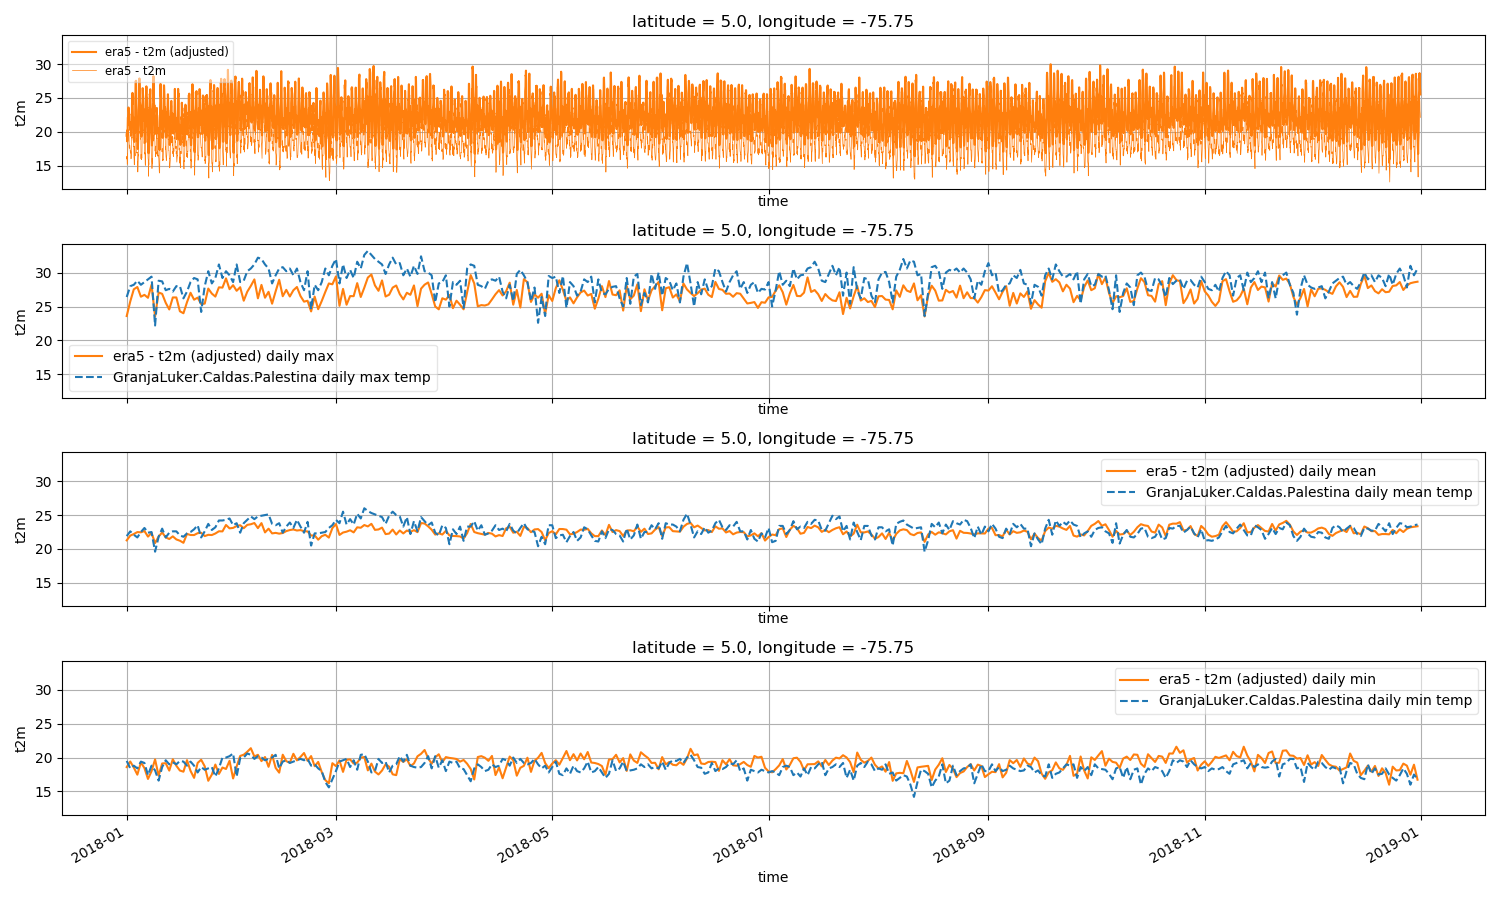

In [7]:
# Plot ERA5 t2m data

fig, (ax, bx, cx, dx) = plt.subplots(4, 1, sharex=True, sharey=True)
fig.set_size_inches(15.0, 9.0)
      
# Kelvin to Celcius
getattr(era5_t2m_adjusted, subproduct).plot(ax=ax,
    label=f'{product} - {subproduct} (adjusted)', color='C1')


getattr(era5_t2m, subproduct).plot(ax=ax, label=f'{product} - {subproduct}',
                                   lw=0.5, color='C1')

ax.legend(loc='best', fontsize='small',
          fancybox=True, framealpha=0.5)

    
# Plot station data

t2m_adjusted_max = era5_t2m_adjusted.t2m.resample(time='24H').reduce(np.max)
t2m_adjusted_max.plot(ax=bx, label=f'{product} - {subproduct} (adjusted) daily max', color='C1')

bx.plot(t2m_adjusted_max.time.data, station.max_temp.values,
        label=f'{site_name} daily max temp', color='C0', ls='--')


t2m_adjusted_mean = era5_t2m_adjusted.t2m.resample(time='24H').reduce(np.mean)
t2m_adjusted_mean.plot(ax=cx, label=f'{product} - {subproduct} (adjusted) daily mean', color='C1')

cx.plot(t2m_adjusted_mean.time.data, station.mean_temp.values,
        label=f'{site_name} daily mean temp', color='C0', ls='--')


t2m_adjusted_min = era5_t2m_adjusted.t2m.resample(time='24H').reduce(np.min)
t2m_adjusted_min.plot(ax=dx, label=f'{product} - {subproduct} (adjusted) daily min', color='C1')

dx.plot(t2m_adjusted_min.time.data, station.min_temp.values,
        label=f'{site_name} daily min temp', color='C0', ls='--')

bx.legend(loc='best', fontsize='medium',
          fancybox=True, framealpha=0.5)
cx.legend(loc='best', fontsize='medium',
          fancybox=True, framealpha=0.5)
dx.legend(loc='best', fontsize='medium',
          fancybox=True, framealpha=0.5)

#station.min_temp.plot(ax=bx)
#station.max_temp.plot(ax=bx)

ax.grid() ; bx.grid() ; cx.grid() ; dx.grid()

plt.tight_layout()
plt.show()


<IPython.core.display.Javascript object>


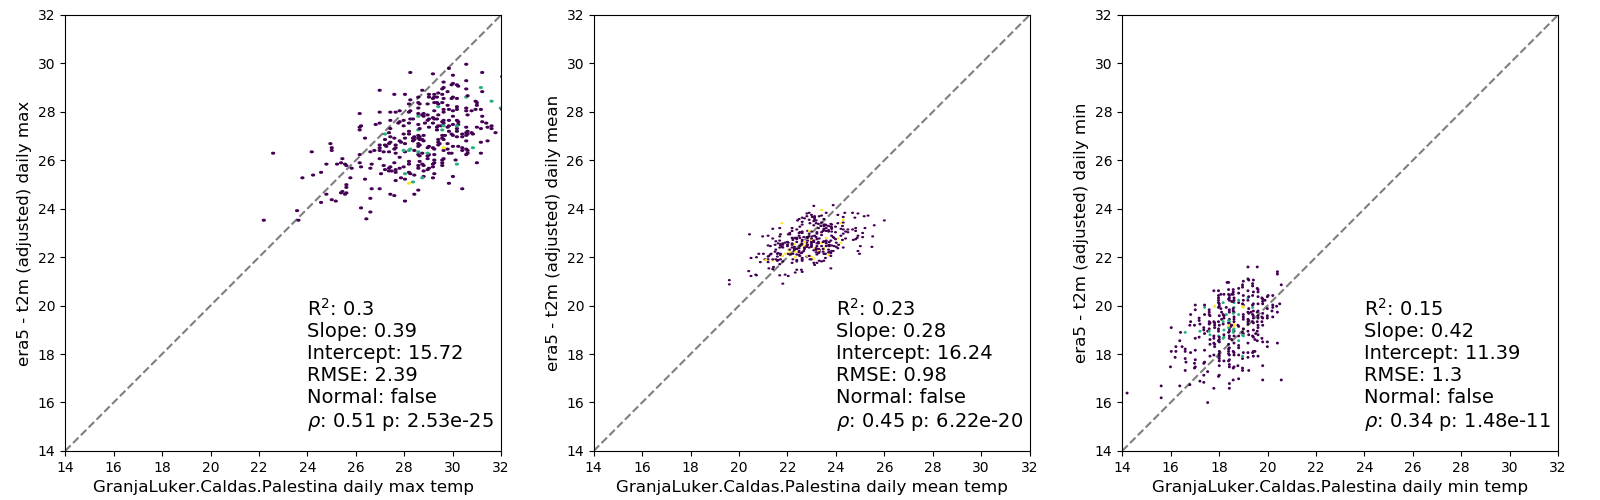

In [8]:
_fig, (_ax, _bx, _cx) = plt.subplots(1, 3)
_fig.set_size_inches(16.0, 5.0)

_ax.hexbin(station.max_temp.values, t2m_adjusted_max.values, bins='log', gridsize=100, mincnt=1)
_bx.hexbin(station.mean_temp.values, t2m_adjusted_mean.values, bins='log', gridsize=100, mincnt=1)
_cx.hexbin(station.min_temp.values, t2m_adjusted_min.values, bins='log', gridsize=100, mincnt=1)

# Linear regression and normality test
slope, intercept, r_value, p_value, std_err = stats.linregress(station.max_temp.values, t2m_adjusted_max.values)
max_r_squared = round(r_value ** 2, 2)
max_slope = round(slope, 2)
max_intercept = round(intercept, 2)
max_rmse = round(np.sqrt(np.mean((t2m_adjusted_max.values - station.max_temp.values)**2)), 2)
max_rho, max_pval = spearmanr(station.max_temp.values, t2m_adjusted_max.values)
max_rho, max_pval = round(max_rho, 2), "{:.2e}".format(max_pval)

k2, p = stats.normaltest(t2m_adjusted_max.values)
alpha = 1e-3
if p < alpha:
    max_p_text = "true"
else:
    max_p_text = "false"

slope, intercept, r_value, p_value, std_err = stats.linregress(station.mean_temp.values, t2m_adjusted_mean.values)
mean_r_squared = round(r_value ** 2, 2)
mean_slope = round(slope, 2)
mean_intercept = round(intercept, 2)
mean_rmse = round(np.sqrt(np.mean((t2m_adjusted_mean.values - station.mean_temp.values)**2)), 2)
mean_rho, mean_pval = spearmanr(station.mean_temp.values, t2m_adjusted_mean.values)
mean_rho, mean_pval = round(mean_rho, 2), "{:.2e}".format(mean_pval)

k2, p = stats.normaltest(t2m_adjusted_mean.values)
alpha = 1e-3
if p < alpha:
    mean_p_text = "true"
else:
    mean_p_text = "false"

slope, intercept, r_value, p_value, std_err = stats.linregress(station.min_temp.values, t2m_adjusted_min.values)
min_r_squared = round(r_value ** 2, 2)
min_slope = round(slope, 2)
min_intercept = round(intercept, 2)
min_rmse = round(np.sqrt(np.mean((t2m_adjusted_min.values - station.min_temp.values)**2)), 2)
min_rho, min_pval = spearmanr(station.min_temp.values, t2m_adjusted_min.values)
min_rho, min_pval = round(min_rho, 2), "{:.2e}".format(min_pval)

k2, p = stats.normaltest(t2m_adjusted_min.values)
alpha = 1e-3
if p < alpha:
    min_p_text = "true"
else:
    min_p_text = "false"

# Plot regression results
_ax.text(24, 15,
         "R$^{2}$: " + str(max_r_squared) +  "\n"\
         "Slope: " + str(max_slope) +  "\n"\
         "Intercept: " + str(max_intercept) +  "\n"\
         "RMSE: " + str(max_rmse) +  "\n"\
         "Normal: " + max_p_text  +  "\n"\
         "$\\rho$: " + str(max_rho) + " p: " + str(max_pval),
          size=14)

_bx.text(24, 15,
         "R$^{2}$: " + str(mean_r_squared) +  "\n"\
         "Slope: " + str(mean_slope) +  "\n"\
         "Intercept: " + str(mean_intercept) +  "\n"\
         "RMSE: " + str(mean_rmse) +  "\n"\
         "Normal: " + mean_p_text  +  "\n"\
         "$\\rho$: " + str(mean_rho) + " p: " + str(mean_pval),
          size=14)

_cx.text(24, 15,
         "R$^{2}$: " + str(min_r_squared) +  "\n"\
         "Slope: " + str(min_slope) +  "\n"\
         "Intercept: " + str(min_intercept) +  "\n"\
         "RMSE: " + str(min_rmse) +  "\n"\
         "Normal: " + min_p_text  +  "\n"\
         "$\\rho$: " + str(min_rho) + " p: " + str(min_pval),
          size=14)

_ax.set_aspect('equal')
_bx.set_aspect('equal')
_cx.set_aspect('equal')

_ax.set(xlim=(14.0, 32.0), ylim=(14.0, 32.0))
_bx.set(xlim=(14.0, 32.0), ylim=(14.0, 32.0))
_cx.set(xlim=(14.0, 32.0), ylim=(14.0, 32.0))

_ax.plot([14,32], [14,32], '--', color='black', alpha=0.5)
_bx.plot([14,32], [14,32], '--', color='black', alpha=0.5)
_cx.plot([14,32], [14,32], '--', color='black', alpha=0.5)

_ax.set_xlabel(f'{site_name} daily max temp', fontsize=12)
_bx.set_xlabel(f'{site_name} daily mean temp', fontsize=12)
_cx.set_xlabel(f'{site_name} daily min temp', fontsize=12)

_ax.set_ylabel(f'{product} - {subproduct} (adjusted) daily max', fontsize=12)
_bx.set_ylabel(f'{product} - {subproduct} (adjusted) daily mean', fontsize=12)
_cx.set_ylabel(f'{product} - {subproduct} (adjusted) daily min', fontsize=12)


_fig.tight_layout()

plt.show()

## El Ciprés station in Caldas, Salamina
 * **Latitude:** 5.433 **Longitude:** -75.5 **Elevation:** 1877m

In [9]:
# Get ERA5 data
product = 'era5'
subproduct = 't2m'

start = '2018-01-01'
end = '2019-01-01'

# (base) glopez@dragon:/media/DataShare/Taylor/COLOMBIA/era5$ gdallocationinfo -wgs84 orography.tif -75.5 5.433
# Report:
#   Location: (30P,34L)
#   Band 1:
#     Value: -27039
#      Descaled Value: 1551.76381431427

# Elevation derived from ERA5 surface geopotential (m)
# elev_geopotential = 2077.79547322085

site_name = 'ElCipres.Caldas.Salamina'
fname = f'../data/{site_name}.csv'
station = read_station_data(fname)

lat, lon = 5.433, -75.5
elevation, elev_geopotential = 1877.0, 2077.79547322085

era5_t2m, era5_t2m_adjusted = get_data_for_station(product, subproduct, lat, lon, elevation, elev_geopotential, start, end)

<IPython.core.display.Javascript object>


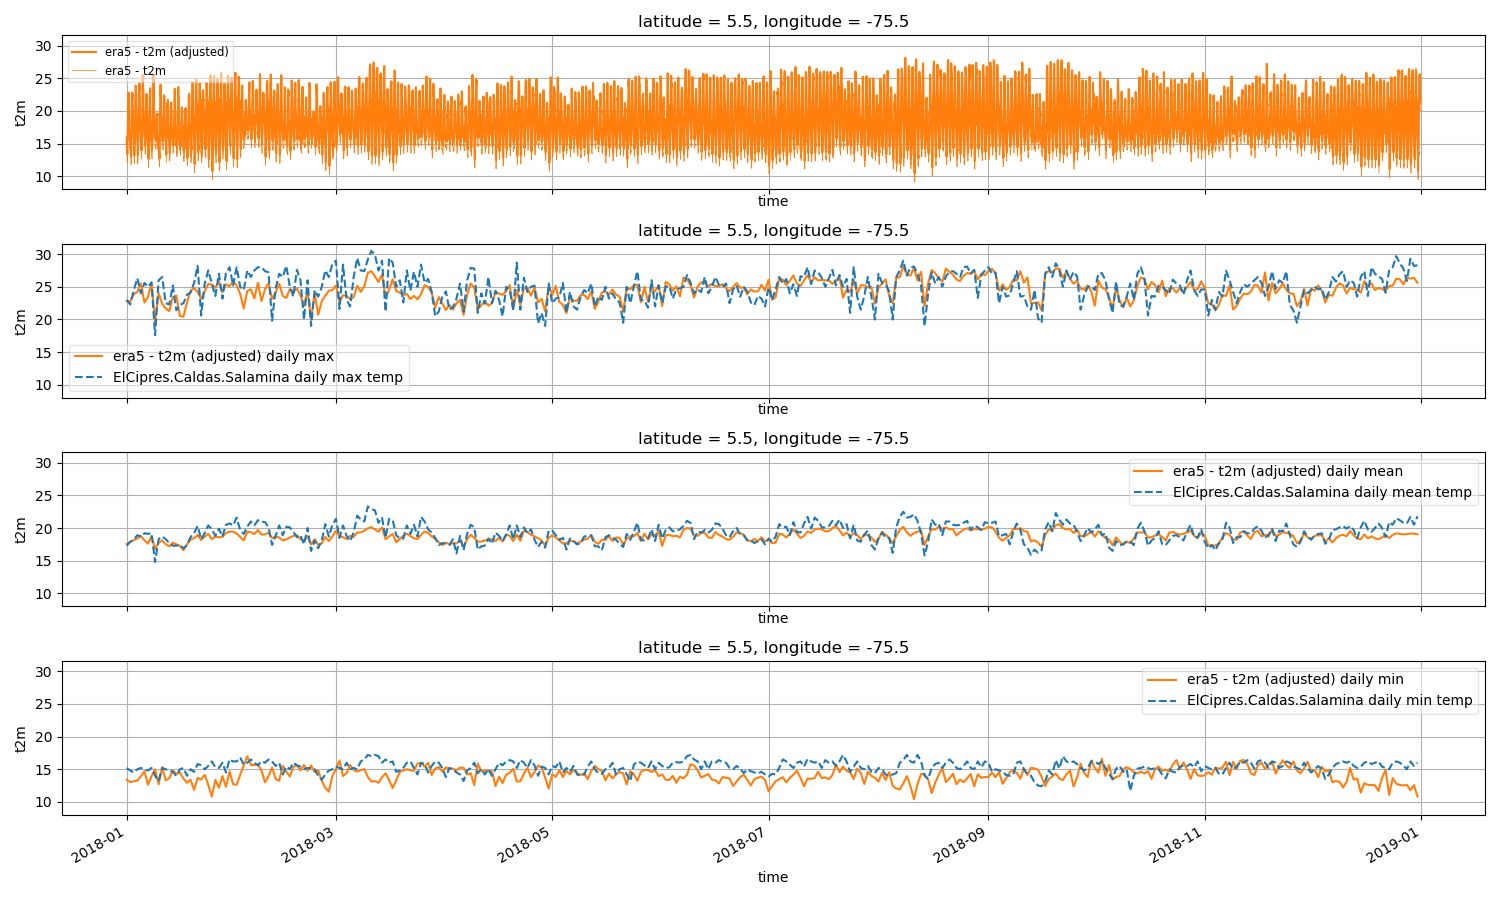

In [10]:
# Plot ERA5 t2m data

fig, (ax, bx, cx, dx) = plt.subplots(4, 1, sharex=True, sharey=True)
fig.set_size_inches(15.0, 9.0)
      
# Kelvin to Celcius
getattr(era5_t2m_adjusted, subproduct).plot(ax=ax,
    label=f'{product} - {subproduct} (adjusted)', color='C1')


getattr(era5_t2m, subproduct).plot(ax=ax, label=f'{product} - {subproduct}',
                                   lw=0.5, color='C1')

ax.legend(loc='best', fontsize='small',
          fancybox=True, framealpha=0.5)

    
# Plot station data

t2m_adjusted_max = era5_t2m_adjusted.t2m.resample(time='24H').reduce(np.max)
t2m_adjusted_max.plot(ax=bx, label=f'{product} - {subproduct} (adjusted) daily max', color='C1')

bx.plot(t2m_adjusted_max.time.data, station.max_temp.values,
        label=f'{site_name} daily max temp', color='C0', ls='--')


t2m_adjusted_mean = era5_t2m_adjusted.t2m.resample(time='24H').reduce(np.mean)
t2m_adjusted_mean.plot(ax=cx, label=f'{product} - {subproduct} (adjusted) daily mean', color='C1')

cx.plot(t2m_adjusted_mean.time.data, station.mean_temp.values,
        label=f'{site_name} daily mean temp', color='C0', ls='--')


t2m_adjusted_min = era5_t2m_adjusted.t2m.resample(time='24H').reduce(np.min)
t2m_adjusted_min.plot(ax=dx, label=f'{product} - {subproduct} (adjusted) daily min', color='C1')

dx.plot(t2m_adjusted_min.time.data, station.min_temp.values,
        label=f'{site_name} daily min temp', color='C0', ls='--')

bx.legend(loc='best', fontsize='medium',
          fancybox=True, framealpha=0.5)
cx.legend(loc='best', fontsize='medium',
          fancybox=True, framealpha=0.5)
dx.legend(loc='best', fontsize='medium',
          fancybox=True, framealpha=0.5)

#station.min_temp.plot(ax=bx)
#station.max_temp.plot(ax=bx)

ax.grid() ; bx.grid() ; cx.grid() ; dx.grid()

plt.tight_layout()
plt.show()


<IPython.core.display.Javascript object>


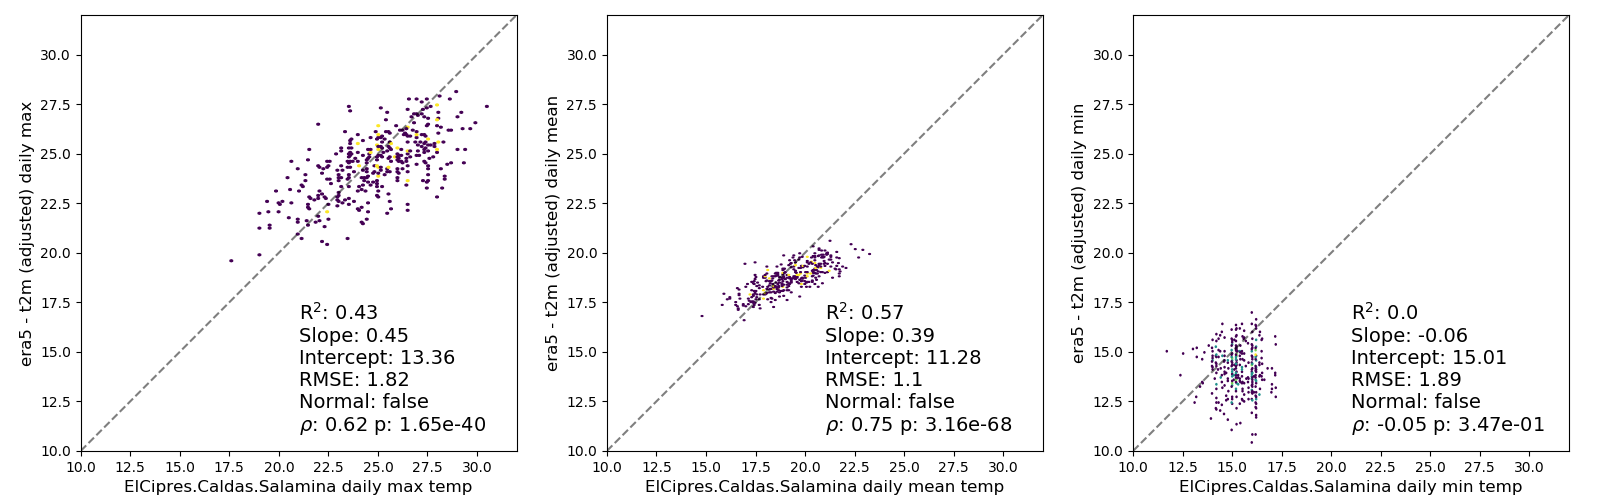

In [11]:
_fig, (_ax, _bx, _cx) = plt.subplots(1, 3)
_fig.set_size_inches(16.0, 5.0)

_ax.hexbin(station.max_temp.values, t2m_adjusted_max.values, bins='log', gridsize=100, mincnt=1)
_bx.hexbin(station.mean_temp.values, t2m_adjusted_mean.values, bins='log', gridsize=100, mincnt=1)
_cx.hexbin(station.min_temp.values, t2m_adjusted_min.values, bins='log', gridsize=100, mincnt=1)

# Linear regression and normality test
slope, intercept, r_value, p_value, std_err = stats.linregress(station.max_temp.values, t2m_adjusted_max.values)
max_r_squared = round(r_value ** 2, 2)
max_slope = round(slope, 2)
max_intercept = round(intercept, 2)
max_rmse = round(np.sqrt(np.mean((t2m_adjusted_max.values - station.max_temp.values)**2)), 2)
max_rho, max_pval = spearmanr(station.max_temp.values, t2m_adjusted_max.values)
max_rho, max_pval = round(max_rho, 2), "{:.2e}".format(max_pval)

k2, p = stats.normaltest(t2m_adjusted_max.values)
alpha = 1e-3
if p < alpha:
    max_p_text = "true"
else:
    max_p_text = "false"

slope, intercept, r_value, p_value, std_err = stats.linregress(station.mean_temp.values, t2m_adjusted_mean.values)
mean_r_squared = round(r_value ** 2, 2)
mean_slope = round(slope, 2)
mean_intercept = round(intercept, 2)
mean_rmse = round(np.sqrt(np.mean((t2m_adjusted_mean.values - station.mean_temp.values)**2)), 2)
mean_rho, mean_pval = spearmanr(station.mean_temp.values, t2m_adjusted_mean.values)
mean_rho, mean_pval = round(mean_rho, 2), "{:.2e}".format(mean_pval)

k2, p = stats.normaltest(t2m_adjusted_mean.values)
alpha = 1e-3
if p < alpha:
    mean_p_text = "true"
else:
    mean_p_text = "false"

slope, intercept, r_value, p_value, std_err = stats.linregress(station.min_temp.values, t2m_adjusted_min.values)
min_r_squared = round(r_value ** 2, 2)
min_slope = round(slope, 2)
min_intercept = round(intercept, 2)
min_rmse = round(np.sqrt(np.mean((t2m_adjusted_min.values - station.min_temp.values)**2)), 2)
min_rho, min_pval = spearmanr(station.min_temp.values, t2m_adjusted_min.values)
min_rho, min_pval = round(min_rho, 2), "{:.2e}".format(min_pval)

k2, p = stats.normaltest(t2m_adjusted_min.values)
alpha = 1e-3
if p < alpha:
    min_p_text = "true"
else:
    min_p_text = "false"

# Plot regression results
_ax.text(21, 11,
         "R$^{2}$: " + str(max_r_squared) +  "\n"\
         "Slope: " + str(max_slope) +  "\n"\
         "Intercept: " + str(max_intercept) +  "\n"\
         "RMSE: " + str(max_rmse) +  "\n"\
         "Normal: " + max_p_text  +  "\n"\
         "$\\rho$: " + str(max_rho) + " p: " + str(max_pval),
          size=14)

_bx.text(21, 11,
         "R$^{2}$: " + str(mean_r_squared) +  "\n"\
         "Slope: " + str(mean_slope) +  "\n"\
         "Intercept: " + str(mean_intercept) +  "\n"\
         "RMSE: " + str(mean_rmse) +  "\n"\
         "Normal: " + mean_p_text  +  "\n"\
         "$\\rho$: " + str(mean_rho) + " p: " + str(mean_pval),
          size=14)

_cx.text(21, 11,
         "R$^{2}$: " + str(min_r_squared) +  "\n"\
         "Slope: " + str(min_slope) +  "\n"\
         "Intercept: " + str(min_intercept) +  "\n"\
         "RMSE: " + str(min_rmse) +  "\n"\
         "Normal: " + min_p_text  +  "\n"\
         "$\\rho$: " + str(min_rho) + " p: " + str(min_pval),
          size=14)

_ax.set_aspect('equal')
_bx.set_aspect('equal')
_cx.set_aspect('equal')

_ax.set(xlim=(10.0, 32.0), ylim=(10.0, 32.0))
_bx.set(xlim=(10.0, 32.0), ylim=(10.0, 32.0))
_cx.set(xlim=(10.0, 32.0), ylim=(10.0, 32.0))

_ax.plot([10,32], [10,32], '--', color='black', alpha=0.5)
_bx.plot([10,32], [10,32], '--', color='black', alpha=0.5)
_cx.plot([10,32], [10,32], '--', color='black', alpha=0.5)

_ax.set_xlabel(f'{site_name} daily max temp', fontsize=12)
_bx.set_xlabel(f'{site_name} daily mean temp', fontsize=12)
_cx.set_xlabel(f'{site_name} daily min temp', fontsize=12)

_ax.set_ylabel(f'{product} - {subproduct} (adjusted) daily max', fontsize=12)
_bx.set_ylabel(f'{product} - {subproduct} (adjusted) daily mean', fontsize=12)
_cx.set_ylabel(f'{product} - {subproduct} (adjusted) daily min', fontsize=12)


_fig.tight_layout()

plt.show()